# Clasificador de imágenes

In [10]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import to_categorical
#from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Configurar para usar la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Configuración de parámetros

In [12]:
width_shape = 280
height_shape = 280
num_classes = 38
epochs = 5
batch_size = 32 

# Path de dataset

In [13]:
train_data_dir = 'C:/Users/pvoid/IA_II/Test02_Redux/New Plant Diseases Dataset(Redux)/train'  
validation_data_dir = 'C:/Users/pvoid/IA_II/Test02_Redux/New Plant Diseases Dataset(Redux)/valid'

# Generador de imágenes (entrenamiento y validación)

In [14]:
train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')




Found 19456 images belonging to 38 classes.
Found 4864 images belonging to 38 classes.


# Entrenamiento de modelo VGG16

In [15]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.applications import VGG16
nb_train_samples = 19456
nb_validation_samples = 4864
# Definir la arquitectura de tu modelo personalizado
image_input = Input(shape=(width_shape, height_shape, 3))

# Cargar el modelo VGG16 preentrenado sin la capa densa 'fc2'
base_model = VGG16(input_tensor=image_input, include_top=False, weights='imagenet')

# Añadir tu propia capa 'fc1' con la forma correcta
x = base_model.output
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)  # Asegúrate de que la forma sea (None, 4096)
out = Dense(num_classes, activation='softmax', name='output')(x)

# Crear el modelo personalizado
custom_vgg_model = Model(inputs=base_model.input, outputs=out)

# Congelar las capas preentrenadas
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

# Imprimir el resumen del modelo
custom_vgg_model.summary()

# Entrenar el modelo
model_history = custom_vgg_model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_steps=nb_validation_samples // batch_size
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 280, 280, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 280, 280, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 280, 280, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 140, 140, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 140, 140, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 140, 140, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 70, 70, 128)       0   

C:\Users\pvoid\AppData\Local\Temp\ipykernel_2532\377847481.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = custom_vgg_model.fit_generator(


Epoch 1/5
 87/608 [===>..........................] - ETA: 42:06 - loss: 11.3104 - accuracy: 0.0402

KeyboardInterrupt: 

# Grabar modelo en disco

In [6]:
custom_vgg_model.save("models/model_VGG16.h5")

# Gráficas de entrenamiento y validación (accuracy - loss)

In [7]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

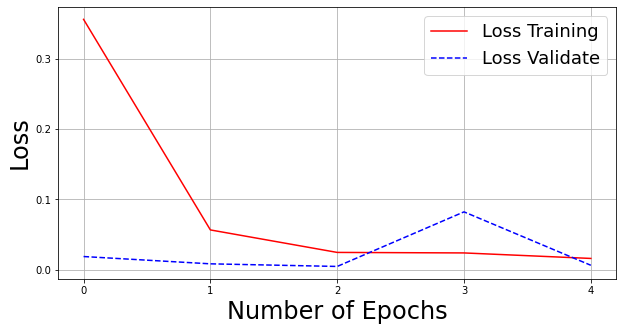

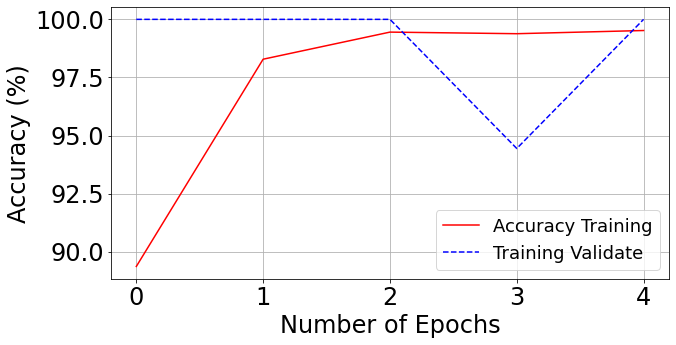

In [8]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

AMERICAN AVOCET


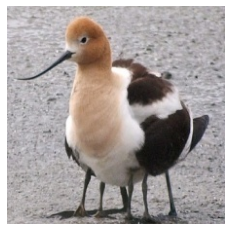

In [9]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model

names = ['AFRICAN FIREFINCH','ALBATROSS','ALEXANDRINE PARAKEET','AMERICAN AVOCET','AMERICAN BITTERN',
         'AMERICAN COOT','AMERICAN GOLDFINCH','AMERICAN KESTREL','AMERICAN PIPIT','AMERICAN REDSTART']

modelt = load_model("models/model_VGG16.h5")
#modelt = custom_vgg_model

imaget_path = "ImagenPrueba.jpg"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [1]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

# Configurar para usar la GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

width_shape = 280
height_shape = 280
num_classes = 38
epochs = 5
batch_size = 32 

train_data_dir = 'C:/Users/pvoid/IA_II/Test02_Redux/New Plant Diseases Dataset(Redux)/train'  
validation_data_dir = 'C:/Users/pvoid/IA_II/Test02_Redux/New Plant Diseases Dataset(Redux)/valid'

train_datagen = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical')

# Definir la arquitectura de tu modelo personalizado
image_input = Input(shape=(width_shape, height_shape, 3))

# Cargar el modelo VGG16 preentrenado sin la capa densa 'fc2'
base_model = VGG16(input_tensor=image_input, include_top=False, weights='imagenet')

# Añadir tu propia capa 'fc1' con la forma correcta
x = base_model.output
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)

# Crear el modelo personalizado
custom_vgg_model = Model(inputs=base_model.input, outputs=out)

# Congelar las capas preentrenadas
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

# Imprimir el resumen del modelo
custom_vgg_model.summary()

# Entrenar el modelo
model_history = custom_vgg_model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)


Found 19456 images belonging to 38 classes.
Found 4864 images belonging to 38 classes.



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 280, 280, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 280, 280, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 280, 280, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 140, 140, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 140, 140, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 140, 140, 128)     147584    
                                    

C:\Users\pvoid\AppData\Local\Temp\ipykernel_3444\3463575948.py:78: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = custom_vgg_model.fit_generator(


Epoch 1/5


608/608 [==============================] - 3420s 6s/step - loss: 7.5800 - accuracy: 0.1619 - val_loss: 4.9593 - val_accuracy: 0.2913
Epoch 2/5
608/608 [==============================] - 3399s 6s/step - loss: 3.8112 - accuracy: 0.4013 - val_loss: 3.1416 - val_accuracy: 0.4741
Epoch 3/5
608/608 [==============================] - 3404s 6s/step - loss: 2.6244 - accuracy: 0.5366 - val_loss: 2.3454 - val_accuracy: 0.5787
Epoch 4/5
608/608 [==============================] - 3406s 6s/step - loss: 1.9893 - accuracy: 0.6313 - val_loss: 2.0013 - val_accuracy: 0.6328
Epoch 5/5
608/608 [==============================] - 3420s 6s/step - loss: 1.6750 - accuracy: 0.6751 - val_loss: 1.6334 - val_accuracy: 0.6791


In [7]:
custom_vgg_model.save("models/model_VGG16.h5")

In [2]:
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

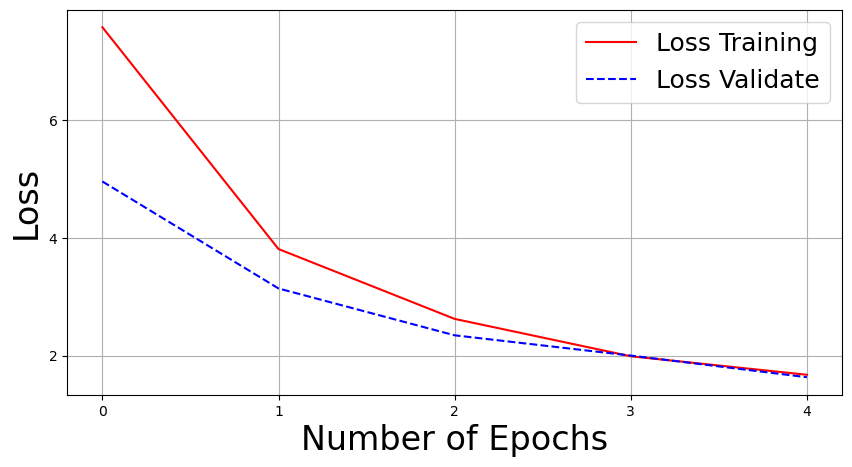

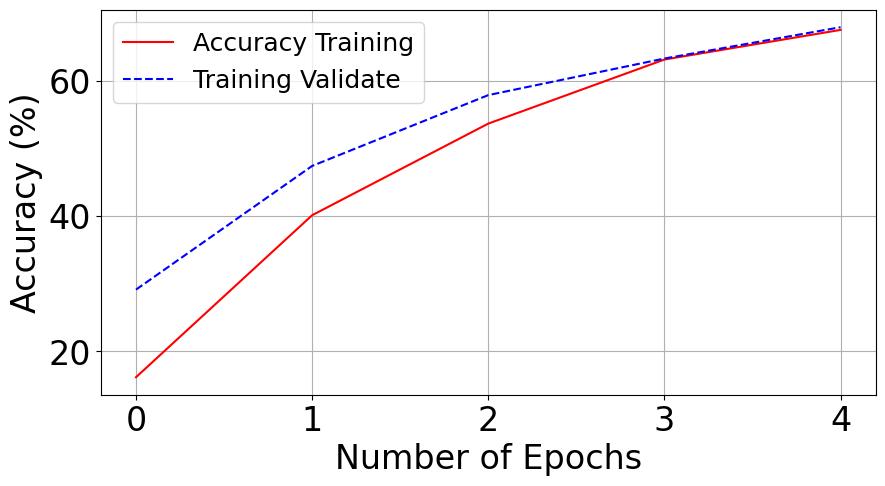

In [4]:
import matplotlib.pyplot as plt
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")